## Import library

In [1]:
from keras.models import load_model
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2024-10-13 21:36:35.136127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 21:36:35.136158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 21:36:35.137398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 21:36:35.142805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 21:36:35.653395: W tensorflow/compiler/tf2

## Load pre-processed data and labels

In [2]:
# load data
phase_data = np.load('./data/signal_events/random_1.5w_1008_bp.npy')

#Normalized trace-by-trace
max_values_per_event = np.max(phase_data, axis=1)
# Normalize each component of each event by dividing by its maximum value
normalized_phase_data = phase_data / max_values_per_event[:, np.newaxis, :]

# Load labels
phase_label = np.load('./data/arrival_time/guassian_picking_labels_all_txed_signal_random_1.5w.npy')
P_phase_label = phase_label[:, :, 0]
S_phase_label = phase_label[:, :, 1]
# P_phase_label = np.load('./data/arrival_time/guassian_picking_labels_Pwave_txed_signal_random_1.5w.npy')
# S_phase_label = np.load('./data/arrival_time/guassian_picking_labels_Swave_txed_signal_random_1.5w.npy')

print(f'shape of testing set: {normalized_phase_data.shape}\tshape of testing label: {phase_label.shape}')

shape of testing set: (15000, 6000, 3)	shape of testing label: (15000, 6000, 2)


## load pretrained models and network inference

In [3]:
learning_rate = 0.001  # Specify your learning rate

P_phase_model = load_model(f'./model/r2_model/P_wave_phase_picking_10w_random_1006_256_100.h5')
S_phase_model = load_model(f'./model/final/S_wave_phase_picking_10w_random_1006_256_200.h5')

P_phase_output = P_phase_model.predict(normalized_phase_data)
S_phase_output = S_phase_model.predict(normalized_phase_data)

2024-10-13 21:36:40.016858: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-13 21:36:40.017076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-13 21:36:40.049696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

469/469 [==============================] - 7s 14ms/step


## Define evaluation metrics

In [4]:
def evaluate_picking(pred_array, label_array):
    pred_indx_array = []
    label_indx_array = []
    for i in range (pred_array.shape[0]-1):
        pred_indx = np.argmax(pred_array[i, :])
        label_indx = np.argmax(label_array[i, :])
        pred_indx_array.append(pred_indx)
        label_indx_array.append(label_indx)

    pred_indx_array = np.array(pred_indx_array)
    label_indx_array = np.array(label_indx_array)

    # calculate the error index
    err_indx_array = label_indx_array- pred_indx_array

    return err_indx_array

def cal_mae_std(input_array, m):
    # from sample to seconds
    input_array = input_array/100
    # filter those outliers
    input_array[(input_array > m) | (input_array < -m)] = 0

    # calculate the evaluation metrics
    mae = np.mean(np.abs(input_array - np.mean(input_array)))
    std = np.std(input_array)

    # calculate the precision of picking results (within ±1 s)
    precision = (np.sum(np.abs(input_array) <= 1) / len(input_array)) * 100
    
    return input_array, mae, std, precision 


def plot_histogram(input_array, input_mae, input_std, input_color, input_name):
    plt.hist(input_array, bins=30, color=f'{input_color}', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
    plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
    plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
    plt.text(0.2, 0.8, f'MAE={input_mae:.2f} s\n$\sigma$={input_std:.2f} s', fontsize=10, fontweight='bold', transform=plt.gcf().transFigure)
    plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
    plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
    plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
    plt.legend([f'{input_name}'], prop={'weight': 'bold'})

## Load the metrics predicted by EQCCT

In [5]:
# Load the CSV file (Please change the path to the output of EQCCT)
df_p = pd.read_csv('/results/X_test_results_EQCCT_P_retrain.csv')
df_s = pd.read_csv('/results/X_test_results_EQCCT_S_retrain.csv')

# Filter out rows where 'P_error' is NaN
filtered_df_p = df_p[df_p['P_error'].notna()]
filtered_df_s = df_s[df_s['s_error'].notna()]

# Convert the 'P_error' column to a NumPy array
EQCCT_P_error_indx = filtered_df_p['P_error'].to_numpy()
EQCCT_S_error_indx = filtered_df_s['s_error'].to_numpy()

print(f'Shape of P-wave picking:{EQCCT_P_error_indx.shape[0]}\nShape of S-wave picking:{EQCCT_S_error_indx.shape[0]}')

Shape of P-wave picking:14838
Shape of S-wave picking:14782


## Caculate the results

In [6]:
# calculate error array for each method
Proposed_P_error_indx = evaluate_picking(P_phase_output, P_phase_label)
Proposed_S_error_indx = evaluate_picking(S_phase_output, S_phase_label)

# evalute the performance of each method
xx = 4
P_error_array_eqcct, mae_P_eqcct, std_P_eqcct, precision_P_eqcct = cal_mae_std(EQCCT_P_error_indx, xx)
S_error_array_eqcct, mae_S_eqcct, std_S_eqcct, precision_S_eqcct = cal_mae_std(EQCCT_S_error_indx, xx)
P_error_proposed, mae_P_proposed, std_P_proposed, precision_P_proposed = cal_mae_std(Proposed_P_error_indx, xx)
S_error_proposed, mae_S_proposed, std_S_proposed, precision_S_proposed = cal_mae_std(Proposed_S_error_indx, xx)

print(f'P-wave MAE and sigma of proposed: {mae_P_proposed:.4f} s\t{std_P_proposed:.4f} s\nP-wave MAE and sigma of EQCCT   : {mae_P_eqcct:.4f} s\t{std_P_eqcct:.4f} s')
print(f'S-wave MAE and sigma of proposed: {mae_S_proposed:.4f} s\t{std_S_proposed:.4f} s\nS-wave MAE and sigma of EQCCT   : {mae_S_eqcct:.4f} s\t{std_S_eqcct:.4f} s')
print(f'P-wave precision of proposed: {precision_P_proposed:.2f} %\tS-wave precision of proposed: {precision_S_proposed:.2f} %')
print(f'P-wave precision of EQCCT: {precision_P_eqcct:.2f} %\tS-wave precision of EQCCT: {precision_S_eqcct:.2f} %')

P-wave MAE and sigma of proposed: 0.1903 s	0.5096 s
P-wave MAE and sigma of EQCCT   : 0.1638 s	0.5683 s
S-wave MAE and sigma of proposed: 0.2126 s	0.4738 s
S-wave MAE and sigma of EQCCT   : 0.2355 s	0.5136 s
P-wave precision of proposed: 95.00 %	S-wave precision of proposed: 95.43 %
P-wave precision of EQCCT: 94.32 %	S-wave precision of EQCCT: 94.99 %


## Compare the results

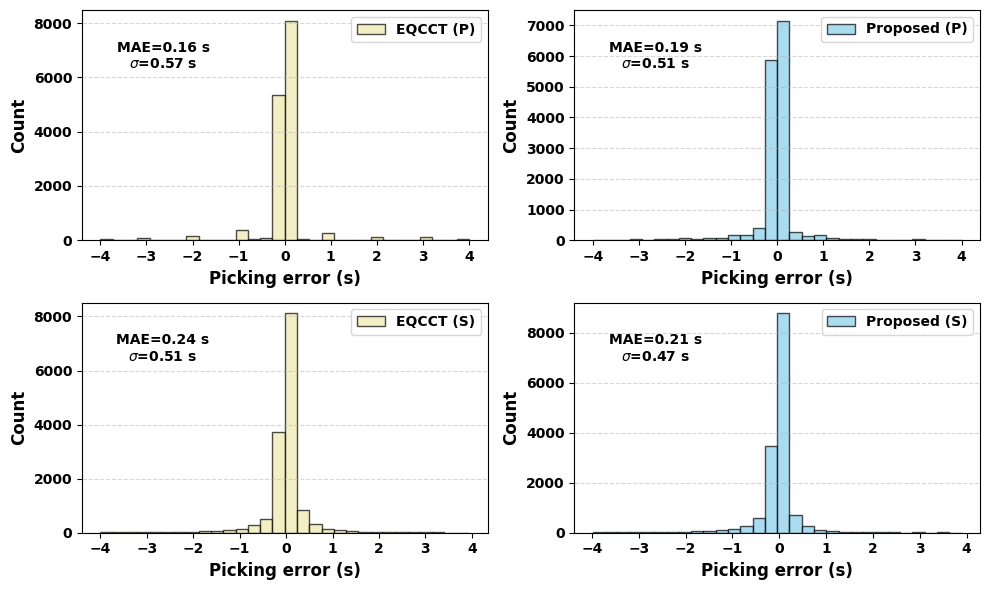

In [7]:
plt.figure(figsize=(10, 6))  # Set figure size
ax = plt.subplot(221)
plt.hist(P_error_array_eqcct, bins=30, color='palegoldenrod', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_P_eqcct:.2f} s\n$\sigma$={std_P_eqcct:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['EQCCT (P)'], prop={'weight': 'bold'})

ax = plt.subplot(222)
plt.hist(P_error_proposed, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_P_proposed:.2f} s\n$\sigma$={std_P_proposed:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Proposed (P)'], prop={'weight': 'bold'})


ax = plt.subplot(223)
plt.hist(S_error_array_eqcct, bins=30, color='palegoldenrod', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_S_eqcct:.2f} s\n$\sigma$={std_S_eqcct:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['EQCCT (S)'], prop={'weight': 'bold'})

ax = plt.subplot(224)
plt.hist(S_error_proposed, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_S_proposed:.2f} s\n$\sigma$={std_S_proposed:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
# plt.text(0.2, 0.8, f'MAE={mae_S_proposed:.2f} s\n$\sigma$={std_S_proposed:.2f} s', fontsize=10, fontweight='bold', transform=plt.gcf().transFigure)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Proposed (S)'], prop={'weight': 'bold'})


plt.tight_layout()

# plt.savefig(f'./figs/r2_picking/compare/EQCCT_vs_proposed.pdf', bbox_inches="tight", dpi=150)
# plt.savefig(f'./figs/r2_picking/compare/EQCCT_vs_proposed.png', bbox_inches="tight", dpi=150)
plt.show()